<a href="https://colab.research.google.com/github/gaveter/Project_cs/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project 2019-20
1. Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.
2. For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time. If any of those two dates is missing, also the duration must be missing.
3. Find the lenders that have funded at least twice.
4. For each country, compute how many loans have involved that country as borrowers.
5. For each country, compute the overall amount of money borrowed.
6. Like the previous point, but expressed as a percentage of the overall amount lent.
7. Like the three previous points, but split for each year (with respect to disburse time).
8. For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount.
9. For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.
10. Which country has the highest ratio between the difference computed at the previous point and the population?
11. Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?
12. For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.

© 2019 GitHub, Inc.

## Install package needed for the project

In [82]:
pip install holidays

In [83]:
pip install forex-python

In [84]:
pip install request

## Load all libraries needed for the project

In [0]:
import pandas as pd
from datetime import datetime, timedelta
import re
import numpy as np
import holidays
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import itertools
import requests
import functools
import calendar
from collections import defaultdict
from forex_python.converter import CurrencyRates

## Task1
- Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.

### Load csv (loans_lenders)

In [86]:
loans_lender = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/loans_lenders.csv')

KeyboardInterrupt: ignored

_Overview_

In [0]:
print("Number rows total: "+str(len(loans_lender)))
loans_lender.head()

### Split each lender for each loan_id

In [0]:
loans_lender["lenders"]=loans_lender["lenders"].str.split(', ') #creazione lista per ogni riga
loans_lender_norm=loans_lender.explode('lenders') #trasformazione ogni elemento della lista come una riga

In [0]:
loans_lender_norm=loans_lender_norm.reset_index(drop=True)

### _Result_

In [0]:
loans_lender_norm.head()

## Task2
- For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time

### Load csv (loans)

In [0]:
loan = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/loans.csv')

_Overview_

In [0]:
loan.dtypes

In [0]:
print('Number rows total: '+str(len(loan)))
loan.head()

### Check missing values

In [0]:
missing_loan_expiration = pd.isnull(loan[['planned_expiration_time']])
missing_loan_disburse = pd.isnull(loan[['disburse_time']])

In [0]:
missing_loan_index_e = missing_loan_expiration[missing_loan_expiration['planned_expiration_time']==True].index
missing_loan_index_d = missing_loan_disburse[missing_loan_disburse['disburse_time']==True].index

In [0]:
print('Number rows which have nan values planned_expiration_time: '+str(len(missing_loan_index_e)))
print('Number rows which have nan values disburse_time: '+str(len(missing_loan_index_d)))

In [0]:
missing_loan_index = missing_loan_index_e.union(missing_loan_index_d) #union indici nan disburse e nan expiration

In [0]:
loan.loc[missing_loan_index][['planned_expiration_time','disburse_time']]

In [0]:
type(loan.loc[67][['planned_expiration_time']][0]), type(loan.loc[68][['planned_expiration_time']][0])

### Conversion attributes
_2 steps_
1. planned_expiration_time, disburse_time to _String_
2. planned_expiration_time, disburse_time to _Datetime_

In [0]:
loan['planned_expiration_time']=loan['planned_expiration_time'].astype(str)
loan['disburse_time']=loan['disburse_time'].astype(str)

In [0]:
loan.loc[64:66][['planned_expiration_time','disburse_time']]

In [0]:
missing = loan.loc[missing_loan_index]
print('Number rows missing: '+str(len(missing)))
print('Ratio missing: '+str(len(missing) / len(loan)))

In [0]:
missing[missing['loan_id']==269368]

In [0]:
loan = loan.drop(missing_loan_index,axis=0) #eliminazione righe che hanno valori nan attributo 'disburse' oppure 'planned_expiration_time'

In [0]:
#set lentissimo 1 minuto e passa
loan['planned_expiration_time']=loan.apply(lambda x: datetime.strptime(x['planned_expiration_time'][:-10],'%Y-%m-%d %H:%M:%S'),axis=1)
loan['disburse_time']=loan.apply(lambda x: datetime.strptime(x['disburse_time'][:-10],'%Y-%m-%d %H:%M:%S'),axis=1)

### Compute difference between planned_expiration_time and disburse_time

In [0]:
loan['duration'] = loan['planned_expiration_time']- loan['disburse_time'] #si ottiene oggetto timedelta
loan['duration'] = loan.apply(lambda x: x['duration'].days,axis=1)

### Function needed to convert date to DateTime (used only for the rows that have nan values)

In [0]:
def convert_date(date):
  if date!='nan':
    date = datetime.strptime(date[:-10],'%Y-%m-%d %H:%M:%S')
  return date

In [0]:
missing['disburse_time'] = missing.apply(lambda x: convert_date(x['disburse_time']),axis=1)

In [0]:
missing['planned_expiration_time'] = missing.apply(lambda x: convert_date(x['planned_expiration_time']),axis=1)

In [0]:
missing[missing['loan_id']==269368][['disburse_time','planned_expiration_time']]

In [0]:
loan = pd.concat([loan,missing],axis=0,sort=False)

### _Result_

In [0]:
loan.head()[['planned_expiration_time','disburse_time','duration']]

## Task 3
- Find the lenders that have funded at least twice

In [0]:
loan['status'].unique()

In [0]:
fundedLoan=loan['loan_id']

### Inner join between lenders_norm and loan

In [0]:
lenders_funded = pd.merge(loans_lender_norm,fundedLoan,how='inner',on='loan_id')
lenders_funded.head()

In [0]:
numberfunded_lenders = lenders_funded.groupby('lenders')['loan_id'].count()

### Apply constraint after group by 

In [0]:
numberfunded_lenders = pd.DataFrame(numberfunded_lenders).reset_index(drop=False)
numberfunded_lenders.columns = ['lenders','count']

numberfunded_lenders = numberfunded_lenders[numberfunded_lenders['count']>=2]

### _Result_

In [0]:
numberfunded_lenders.head()

_Result (ordered)_

In [0]:
numberfunded_lenders.sort_values(by='count',ascending=False)

## Task 4
- For each country, compute how many loans have involved that country as borrowers.

In [0]:
loan[["country_name","funded_amount","loan_amount","num_lenders_total"]]

In [0]:
#esempio per capire situazione
funded=loan[loan['status']=='funded'][['loan_id','country_name','status','currency','funded_amount','loan_amount','num_lenders_total']].head(2)
expired=loan[loan['status']=='expired'][['loan_id','country_name','status','funded_amount','loan_amount','num_lenders_total']].head(2)
refunded=loan[loan['status']=='refunded'][['loan_id','country_name','status','funded_amount','loan_amount','num_lenders_total']].head(2)
fundRaising=loan[loan['status']=='fundRaising'][['loan_id','country_name','status','funded_amount','loan_amount','num_lenders_total']].head(2)

esempio = pd.concat([funded,expired,refunded,fundRaising],axis=0,sort=False)

esempio

### Check missing values

In [0]:
missing = pd.isnull(loan[['country_name']])
missing[missing['country_name']==True]

### Delete rows who have 0 as values 'num_lenders_total'

In [0]:
loan_noZeroLenders = loan[loan['num_lenders_total']!=0]

In [0]:
country_numberLoan = loan_noZeroLenders.groupby('country_name')['status'].count()
country_numberLoan = pd.DataFrame(country_numberLoan).reset_index(drop=False)
country_numberLoan.columns=['country','count']

### _Result_

In [0]:
country_numberLoan.head()

_Result ordered_

In [0]:
country_numberLoan.sort_values(by='count',ascending=False)

## Task 5
- For each country, compute the overall amount of money borrowed.

N.B. For this task I've decided to convert 'funded_amount' to USD for each loan due to need to sum all amount money for each country

### Create object CurrencyRates needed to convert money to USD

In [0]:
'''global currency_list # variabile globale che memorizza tutte le valute dai quali è possibile effettuare conversione in dollari (USD)

currency_object = CurrencyRates()
currency_list = currency_object.get_rates('USD')'''

In [0]:
loan_simplified = loan_noZeroLenders[['loan_id','country_name','disburse_time',
                    'funded_amount','loan_amount','currency']]

### Functions needed to check if date represent week-end or not

In [0]:
def check_weekend(date_time):
  date = date_time.date() #conversione data 
  day_week = date.weekday()
  delta=0
  if (day_week == 5):
    delta = 1
  if (day_week == 6):
    delta = 2
  #print(delta)
  date_r = date - timedelta(delta)
  return date_r

In [173]:
loan_simplified['disburse_time_API'] = loan_simplified.apply(lambda x: check_weekend(x['disburse_time']),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [174]:
loan_simplified['disburse_time_API']=loan_simplified['disburse_time_API'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Check missing values

In [175]:
missing = pd.isnull(loan_simplified[['currency']])
missing[missing['currency']==True]

,currency


In [0]:
date = loan_simplified['disburse_time_API'][0]
request_link = 'https://api.exchangeratesapi.io/history?start_at='+date+"&end_at="+date+"&base=USD"

request_API = requests.get(request_link) #richiesta API
dict_request = request_API.json()

In [0]:
dict_currency_legend = dict_request['rates'][date]

In [0]:
global currency_list_legend

In [0]:
currency_list_legend = dict_currency_legend.keys() #lista currency convertibile

### Functions needed to convert each money amount from current currency to USD

In [0]:
def check_currency(currency): #controlla se valuta corrente è 'convertibile' (esiste tasso di cambio)
  if currency not in currency_list_legend:
    conv = False
  else:
    conv = True
  return conv

In [0]:
def create_dictionary_currency(list_dict): #funzione che crea dizionario da una lista
  dates_dict = defaultdict(list)
  for key, info in list_dict:
    #print(key, info)
    dates_dict[key].append(info)
  return dates_dict

In [0]:
currency_included = pd.DataFrame(loan_simplified['currency'].unique())
currency_included.columns=['currency']
currency_included = currency_included[currency_included['currency']!='USD']

In [0]:
currency_included['conversion'] = currency_included.apply(lambda x: check_currency(x['currency']),axis=1)

### Left join between loans and currency convertible

In [0]:
loan_simplified = pd.merge(loan_simplified,currency_included,how='left',on='currency')

In [0]:
firstBlock = loan_simplified[loan_simplified['conversion']==True] #parte df dove le valute possone essere convertite
firstBlock_index = firstBlock.index

In [187]:
firstBlock.groupby('currency')['loan_id'].count()

currency
BGN        64
BRL       465
CNY       125
EUR      2180
IDR     10041
ILS       467
INR     15069
MXN     17155
PHP    285256
THB       110
TRY      2008
ZAR       596
Name: loan_id, dtype: int64

In [0]:
secondBlock = loan_simplified.drop(firstBlock_index,axis=0)

In [0]:
secondBlock['funded_amount_conversion_USD'] = secondBlock['funded_amount']

### Functions needed to get last business day if date was holiday

In [0]:
def get_last_business_day(date,holidays):
  i=1
  date = date - timedelta(i)
  while date in holidays or date.weekday()>=5:
    date = date - timedelta(1)
  return date
    

def check_holidays(date):
  date_datetime = datetime.strptime(date,'%Y-%m-%d')
  holiday_EU = holidays.EuropeanCentralBank(years = date_datetime.year)
  if date in holiday_EU:
    #print("Festività")
    date_r=get_last_business_day(date_datetime,holiday_EU)
    date_r=date_r.strftime('%Y-%m-%d')
  else:
    date_r=date
  return date_r

In [191]:
firstBlock['disburse_time_API']= firstBlock.apply(lambda x: check_holidays(x['disburse_time_API']),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Functions that use API

In [0]:
def get_pair(currency, date):
  pair = (date,currency)
  return pair

def fill_list_map1(currency, dates):
  dates_list = [item for sublist in dates for item in sublist] #date loan di ogni valuta
  info_rate = list(map (functools.partial(get_pair, currency), dates_list)) #funzione viene passata la stessa valuta
  return info_rate

def create_list_currency_map1(df, currency_list):
  dict_currency_list=list()
  date_loan_list = list()
  for i in currency_list:
    loan_currency = df[df['currency']==i][['disburse_time_API','currency']]
    date_loan_currency = set(loan_currency['disburse_time_API'].tolist()) #elimino date duplicate
    date_loan_list.append([date_loan_currency])

  
  dict_currency_list = list(map(lambda x,y: fill_list_map1(x,y), currency_list, date_loan_list))
  return dict_currency_list

In [0]:
currency = firstBlock['currency'].unique()
dict_currency_list = create_list_currency_map1(firstBlock, currency)

In [0]:
flat_dict_currency_list = [item for sublist in dict_currency_list for item in sublist]
dict_date_currency = create_dictionary_currency(flat_dict_currency_list)

In [0]:
def get_info_from_API(date):
  date = date.strftime('%Y-%m-%d')
  request = 'https://api.exchangeratesapi.io/history?start_at='+date+'&end_at='+date+'&base=USD'
  request_API = requests.get(request)
  dict_API = request_API.json()
  dict_API = dict_API['rates'][date]
  return dict_API

def get_last_date_currency(currency,date):
  #print(date)
  date = datetime.strptime(date,'%Y-%m-%d')
  date = date - timedelta(1)
  dict_result = get_info_from_API(date)
  while currency not in dict_result.keys():
    date = date - timedelta(1)
    dict_result = get_info_from_API(date)
  return dict_result[currency]

In [0]:
def extract_rate(dict_API, date,currency):
  if currency in dict_API.keys():
    rate = dict_API[currency]
  else:
    rate = get_last_date_currency(currency,date)
  return (currency,rate)

def call_API(dict_date,date):
  request = 'https://api.exchangeratesapi.io/history?start_at='+date+'&end_at='+date+'&base=USD'
  request_API = requests.get(request)
  dict_API = request_API.json()
  dict_API = dict_API['rates'][date]
  rate_currency = list(map (functools.partial(extract_rate, dict_API, date), dict_date[date]))
  #print(rate_currency)
  return (date,rate_currency)


def get_list_currency_rate(dates_list,dict_date):
  rate_list = list(map (functools.partial(call_API, dict_date), dates_list))
  return rate_list

In [0]:
dates_request = dict_date_currency.keys() #lista date da usare per chiamare API
dates_request = list(dates_request)

In [208]:
dict_currency_list = get_list_currency_rate(dates_request, dict_date_currency)

KeyError: ignored

In [0]:
dict_currency = create_dictionary_currency(dict_currency_list)

### Create DataFrame that contains for each date currency rates

In [0]:
def flat_list(list):
  return [item for sublist in list for item in sublist]

In [0]:
date_currency = pd.DataFrame(dict_currency.items()) #.items ritorna lista tuple coppia key value
date_currency.columns = ['date','currency']

In [0]:
date_currency['currency']=date_currency.apply(lambda x: flat_list(x['currency']),axis=1)

In [0]:
date_currency = date_currency.explode('currency').reset_index()

In [0]:
date_currency['curr']=date_currency.apply(lambda x: x['currency'][0],axis=1)
date_currency['rate']=date_currency.apply(lambda x: x['currency'][1],axis=1)

In [0]:
date_currency.drop(columns=['index','currency'],inplace=True)

In [95]:
date_currency

,date,curr,rate
0,2011-06-02,PHP,43.223375
1,2011-06-02,ILS,3.400000
2,2011-06-02,MXN,11.675035
3,2012-05-11,PHP,42.523949
4,2012-05-11,ILS,3.815899
...,...,...,...
9506,2013-11-01,IDR,11335.209182
9507,2013-11-01,INR,61.728619
9508,2013-11-01,BRL,2.251685
9509,2013-01-02,INR,54.313075


### Inner join between rows which contains currency convertible and DataFrame created before

In [0]:
firstBlock = pd.merge(firstBlock,date_currency,how='inner',left_on=['disburse_time_API','currency'],right_on = ['date','curr'])

In [0]:
firstBlock.drop(columns=['date','curr'],inplace=True)

In [0]:
firstBlock['funded_amount_conversion_USD']=round(firstBlock['funded_amount']/firstBlock['rate'],2)

In [99]:
firstBlock

,loan_id,country_name,disburse_time,funded_amount,loan_amount,currency,disburse_time_API,rate,funded_amount_conversion_USD
0,657307,Philippines,2013-12-22 08:00:00,125.0,125.0,PHP,2013-12-20,44.547785,2.81
1,654523,Philippines,2013-12-20 08:00:00,400.0,400.0,PHP,2013-12-20,44.547785,8.98
2,657419,Philippines,2013-12-20 08:00:00,350.0,350.0,PHP,2013-12-20,44.547785,7.86
3,652191,Philippines,2013-12-20 08:00:00,250.0,250.0,PHP,2013-12-20,44.547785,5.61
4,657423,Philippines,2013-12-20 08:00:00,450.0,450.0,PHP,2013-12-20,44.547785,10.10
...,...,...,...,...,...,...,...,...,...
333531,375249,Israel,2011-12-22 08:00:00,2650.0,2650.0,ILS,2011-12-22,3.783245,700.46
333532,64211,Indonesia,2008-10-08 07:00:00,325.0,325.0,IDR,2008-10-08,9670.999927,0.03
333533,80498,Philippines,2008-12-03 08:00:00,150.0,150.0,PHP,2008-12-03,49.298899,3.04
333534,182418,Indonesia,2010-02-23 08:00:00,975.0,975.0,IDR,2010-02-23,9299.337114,0.10


In [0]:
loan_simplified_USD = pd.concat([firstBlock,secondBlock],axis=0,sort=False)

In [164]:
loan_simplified_USD[loan_simplified_USD['loan_id']==25930]

,loan_id,country_name,disburse_time,funded_amount,loan_amount,currency,disburse_time_API,rate,funded_amount_conversion_USD,conversion
304407,25930,Mexico,2007-12-14 12:29:15,750.0,750.0,MXN,2007-12-14,0.0,inf,NaN


In [0]:
mexico = loan_simplified_USD[loan_simplified_USD['country_name']=='Mexico'][['loan_id','funded_amount_conversion_USD']]

In [0]:
prova = pd.DataFrame(mexico)

In [161]:
prova[prova['funded_amount_conversion_USD']==np.inf]

,loan_id,funded_amount_conversion_USD
304407,25930,inf
304408,26072,inf
304409,26079,inf
304410,26048,inf
304411,26069,inf
...,...,...
333482,21078,inf
333489,12325,inf
333524,21664,inf
333525,13598,inf


In [155]:
prova['appossimation'] = prova['funded_amount_conversion_USD'].astype(int)

ValueError: ignored

In [0]:
country_amountLoan = pd.DataFrame(loan_simplified_USD.groupby('country_name')['funded_amount_conversion_USD'].sum()).reset_index()

In [122]:
country_amountLoan[country_amountLoan['country_name']=='Mexico']

,country_name,funded_amount_conversion_USD
51,Mexico,inf


### _Result_

In [108]:
country_amountLoan.head()

,country,overall
0,Afghanistan,1964650.00
1,Albania,4017814.39
2,Armenia,20284675.00
3,Azerbaijan,14191350.00
4,Belize,150175.00


_Result (ordered)_

In [109]:
country_amountLoan.sort_values(by='overall',ascending=False)

,country,overall
38,Israel,inf
51,Mexico,inf
65,Peru,78702800.0
40,Kenya,63650255.0
64,Paraguay,53715200.0
...,...,...
90,Vanuatu,9250.0
31,Guam,8700.0
9,Botswana,8000.0
89,Uruguay,8000.0


## Task 6
- Like the previous point, but expressed as a percentage of the overall amount lent.

In [0]:
country_amountLoan_perc=pd.DataFrame(country_amountLoan).reset_index(level=0)
country_amountLoan_perc.columns=['country','total']

In [0]:
total_lent=country_amountLoan_perc['total'].sum()
total_lent

1130185170.0

In [0]:
country_amountLoan_perc['percentage']=round(country_amountLoan_perc['total']/total_lent*100,2)

In [0]:
country_amountLoan_perc.columns=['country','borrowed','percentage']

### Result

In [0]:
country_amountLoan_perc.head()

,country,borrowed,percentage
0,Philippines,97045925.0,8.59
1,Peru,78702800.0,6.96
2,Kenya,63650255.0,5.63
3,Paraguay,53715200.0,4.75
4,Cambodia,50829425.0,4.50


## Task 7
- Like the three previous points, but split for each year (with respect to disburse time).

In [0]:
global loanYear

In [0]:
loanYear = loan[['loan_id','country_name','disburse_time','planned_expiration_time','duration',
                 'funded_amount','loan_amount','currency']]

In [0]:
missing = pd.isnull(loanYear[['disburse_time']])
missing[missing['disburse_time']==True]

,disburse_time


In [0]:
len(loanYear[loanYear['disburse_time']=="nan"])

2813

In [0]:
loanYear = loanYear[loanYear['disburse_time']!='nan']

In [0]:
inizio=datetime.now()
print("Inizio: "+inizio.strftime("%H:%M:%S"))
loanYear['year']=loanYear.apply(lambda x: int(x["disburse_time"].split('-')[0]),axis=1)
fine=datetime.now()
print("Fine: "+fine.strftime("%H:%M:%S"))
diff= fine - inizio
diff

Inizio: 13:05:49
Fine: 13:06:12


datetime.timedelta(0, 22, 360383)

In [0]:
countryAmount_year=loanYear.groupby(['country_name','year'])['funded_amount'].sum()
countryAmount_year = pd.DataFrame(countryAmount_year)

### Result

In [0]:
countryAmount_year.head()

funded_amount
country_name year               
Afghanistan  2007       194975.0
             2008       365375.0
             2009       581825.0
             2010       563350.0
             2011       245125.0

## Task 8
- For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount.

In [0]:
numberLoans_lender_norm=loans_lender_norm.groupby('loan_id')['lenders'].count()
numberLoans_lender_norm=pd.DataFrame(numberLoans_lender_norm).reset_index(level=0)
numberLoans_lender_norm

,loan_id,lenders
0,84,3
1,85,2
2,86,3
3,88,3
4,89,4
...,...,...
1387427,1444051,1
1387428,1444053,1
1387429,1444058,1
1387430,1444063,1


In [0]:
loans_lender = loan[['loan_id','num_lenders_total','funded_amount']]

In [0]:
numberLoans = pd.merge(loans_lender,numberLoans_lender_norm,how="inner",on="loan_id")
numberLoans.head()

,loan_id,num_lenders_total,funded_amount,lenders
0,657307,3,125.0,3
1,657259,11,400.0,7
2,658010,16,400.0,14
3,659347,21,625.0,17
4,656933,15,425.0,14


In [0]:
correct = numberLoans[numberLoans['num_lenders_total']==numberLoans['lenders']]
wrong = numberLoans[numberLoans['num_lenders_total']!=numberLoans['lenders']]

In [0]:
wrong.head()

,loan_id,num_lenders_total,funded_amount,lenders
1,657259,11,400.0,7
2,658010,16,400.0,14
3,659347,21,625.0,17
4,656933,15,425.0,14
5,659605,13,350.0,14


In [0]:
#plot barchart da fare
print("Info giuste: "+str(len(correct)/len(numberLoans)))
print("Info sbagliate: "+str(len(wrong)/len(numberLoans)))

Info giuste: 0.1917209397532701
Info sbagliate: 0.8082790602467299


In [0]:
loans_lender_correct = pd.merge(loans_lender,numberLoans_lender_norm,how='inner',on='loan_id')
loans_lender_correct.drop(columns='num_lenders_total',inplace=True)

In [0]:
loans_lender_correct['amount']=round(loans_lender_correct['funded_amount']/loans_lender_correct['lenders'],2)

In [0]:
loans_lender_correct.head()

,loan_id,funded_amount,lenders,amount
0,657307,125.0,3,41.67
1,657259,400.0,7,57.14
2,658010,400.0,14,28.57
3,659347,625.0,17,36.76
4,656933,425.0,14,30.36


In [0]:
amount_loan_lender = pd.merge(loans_lender_norm,loans_lender_correct,how="inner",on='loan_id')
amount_loan_lender.drop(columns=['funded_amount','lenders_y'],inplace=True)
amount_loan_lender.columns=['loan_id','lenders','amount'] 

In [0]:
amountLender = amount_loan_lender.groupby('lenders')['amount'].sum()
amountLender = pd.DataFrame(amountLender).reset_index(level=0)

In [0]:
amountLender = amountLender.sort_values(by='amount',ascending=False)

In [0]:
amountLender['amountFormat']=amountLender.apply(lambda x: format(x['amount'],'f'),axis=1)

### Result

In [0]:
amountLender.head()

,lenders,amount,amountFormat
462833,gooddogg1,8.140636e+06,8140636.400000
1324411,trolltech4460,5.634790e+06,5634789.740000
1008585,nms,4.453638e+06,4453638.040000
462243,gmct,4.445122e+06,4445122.169999
158450,bob4739,4.439756e+06,4439755.910000


## Task 9
- For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.

### Load 2 csv: lenders and country_stats

In [0]:
lenders = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/lenders.csv')

In [0]:
country_info=pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/country_stats.csv')

In [0]:
country_info_9 = country_info[['country_name','country_code']] #population is included because it needed for the 10 task

In [0]:
lenders = lenders[['permanent_name','country_code']]

In [0]:
lenders['country_code']=lenders.apply(lambda x: str(x['country_code']),axis=1)

In [0]:
lenders['country_code'].unique()

array(['nan', 'US', 'IN', 'AU', 'PL', 'BR', 'CN', 'FR', 'BG', 'AT', 'GB',
       'ES', 'DE', 'BE', 'SK', 'IT', 'SE', 'JP', 'PK', 'LA', 'AR', 'HU',
       'TR', 'LV', 'TW', 'MY', 'NL', 'GE', 'ID', 'RU', 'CA', 'PT', 'NG',
       'IS', 'NO', 'HK', 'JO', 'KE', 'MT', 'VN', 'CH', 'NZ', 'FI', 'MX',
       'TN', 'CO', 'AE', 'KR', 'DK', 'TZ', 'PH', 'GR', 'RO', 'CR', 'IL',
       'SA', 'GH', 'PR', 'VE', 'LK', 'EG', 'MA', 'TH', 'AM', 'PG', 'CZ',
       'SG', 'CL', 'YE', 'CY', 'PY', 'HR', 'MN', 'CM', 'UG', 'LT', 'EE',
       'BH', 'DZ', 'IE', 'RS', 'KY', 'IR', 'GT', 'DO', 'PS', 'PE', 'BD',
       'ET', 'SY', 'UY', 'RW', 'AS', 'PA', 'AL', 'UA', 'EC', 'KW', 'AD',
       'NI', 'ZA', 'MM', 'FJ', 'LC', 'IQ', 'HT', 'AO', 'SD', 'SI', 'MK',
       'OM', 'AQ', 'LY', 'AZ', 'AF', 'MO', 'BS', 'MZ', 'SV', 'ZM', 'LU',
       'HN', 'BI', 'BJ', 'YT', 'GU', 'ML', 'BO', 'GW', 'TJ', 'KH', 'SR',
       'LB', 'VU', 'AN', 'MP', 'MW', 'QA', 'MH', 'TM', 'UM', 'SZ', 'XK',
       'NE', 'TT', 'SO', 'ZW', 'TK', 'BB', 'JM', '

In [0]:
totale = len(lenders)
sconosciuti = len(lenders[lenders['country_code']=='nan'])

In [0]:
print("Country lenders not known: "+str(sconosciuti/totale))

Country lenders not known: 0.620913989342637


In [0]:
country_info

,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
0,India,IN,IND,Asia,Southern Asia,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799,India
1,Nigeria,NG,NGA,Africa,Western Africa,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264,Nigeria
2,Mexico,MX,MEX,Americas,Central America,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680,Mexico
3,Pakistan,PK,PAK,Asia,Southern Asia,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074,Pakistan
4,Bangladesh,BD,BGD,Asia,Southern Asia,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722,Bangladesh
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,Somalia,SO,SOM,Africa,Eastern Africa,14742523,NaN,NaN,NaN,NaN,NaN,NaN,Somalia
170,Central African Republic,CF,CAF,Africa,Middle Africa,4659080,NaN,0.352440,51.458,7.098980,4.230000,587.473961,Central African Republic
171,Samoa,WS,WSM,Oceania,Polynesia,196440,NaN,0.702000,NaN,NaN,NaN,NaN,Samoa
172,Palestine,PS,PS,Asia,Western Asia,4920724,NaN,0.677000,NaN,NaN,NaN,NaN,Palestine


In [0]:
lenders_country = pd.merge(lenders,country_info_9,how='left',on='country_code')
lenders_country.drop(columns='country_code',inplace=True)

In [0]:
lenders_country['country_name'] = lenders_country.apply(lambda x: str(x['country_name']),axis=1)

In [0]:
lenders_country.head()

,permanent_name,country_name
0,qian3013,nan
1,reena6733,nan
2,mai5982,nan
3,andrew86079135,nan
4,nguyen6962,nan


In [0]:
lenders_country.columns=['lenders','country_name']

In [0]:
lenders_country_distTrovati = lenders_country[lenders_country['country_name']!='nan']

In [0]:
lenders_country_distTrovare = lenders_country[lenders_country['country_name']=='nan']

In [0]:
lenders_country_dist = lenders_country_distTrovati.groupby('country_name')['lenders'].count()
lenders_country_dist = pd.DataFrame(lenders_country_dist).reset_index(level=0)

In [0]:
number_lenders = lenders_country_dist['lenders'].sum()
number_lenders

888056

<BarContainer object of 170 artists>

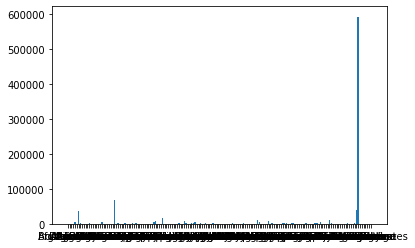

In [0]:
fig = plt.figure()
plt.bar(lenders_country_dist['country_name'],lenders_country_dist['lenders'])

In [0]:
lenders_country_dist['distribution'] = lenders_country_dist['lenders'] / number_lenders

In [0]:
dist= lenders_country_dist.sort_values(by='lenders',ascending=False)

In [0]:
dist

,country_name,lenders,distribution
162,United States,591612,0.666188
26,Canada,67970,0.076538
161,United Kingdom,38380,0.043218
6,Australia,37103,0.041780
53,Germany,16007,0.018025
...,...,...,...
157,Turkmenistan,4,0.000005
44,Eritrea,4,0.000005
96,Mauritania,4,0.000005
30,Comoros,1,0.000001


Text(0, 0.5, 'percentage')

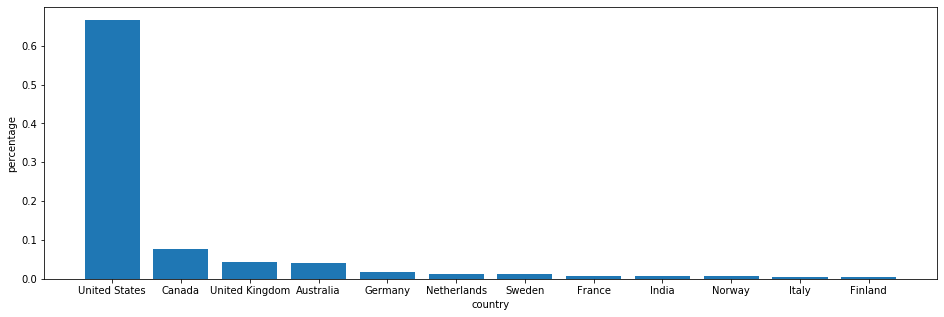

In [0]:
dist_focus = dist[dist['distribution']>0.005]
fig = plt.figure(figsize=(16,5))
plt.bar(dist_focus['country_name'],dist_focus['distribution'])
plt.xlabel('country')
plt.ylabel('percentage')

In [0]:
lenders_country_distTrovare.head()

,lenders,country_name
0,qian3013,nan
1,reena6733,nan
2,mai5982,nan
3,andrew86079135,nan
4,nguyen6962,nan


In [0]:
dist['numberRecord']=round(dist['distribution']*len(lenders_country_distTrovare),0)
dist['numberRecord'] = dist.apply(lambda x: int(x['numberRecord']),axis=1)
dist

,country_name,lenders,distribution,numberRecord
162,United States,591612,0.666188,973379
26,Canada,67970,0.076538,111831
161,United Kingdom,38380,0.043218,63147
6,Australia,37103,0.041780,61046
53,Germany,16007,0.018025,26336
...,...,...,...,...
157,Turkmenistan,4,0.000005,7
44,Eritrea,4,0.000005,7
96,Mauritania,4,0.000005,7
30,Comoros,1,0.000001,2


In [0]:
dist['countryLender']=dist.apply(lambda x: [x['country_name']]*x['numberRecord'],axis=1)

In [0]:
country_lenderTrovare = pd.Series.to_list(dist['countryLender']) #concat all list for each country

In [0]:
country_lenderTrovare = list(itertools.chain(*country_lenderTrovare)) #flat list
country_lenderTrovare = country_lenderTrovare[:-2]

In [0]:
lenders_country_distTrovare['country_name']=country_lenderTrovare

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
lenders_country = pd.concat([lenders_country_distTrovare,lenders_country_distTrovati],axis=0)

In [0]:
lenders_country

,lenders,country_name
0,qian3013,United States
1,reena6733,United States
2,mai5982,United States
3,andrew86079135,United States
4,nguyen6962,United States
...,...,...
2349158,rakhi,United States
2349159,vicki5374,United States
2349161,jennifer5879,Canada
2349171,maria2141,United States


In [0]:
amount_lender_country = pd.merge(amountLender,lenders_country,how='inner',on='lenders')

In [0]:
country_amountLent = amount_lender_country.groupby('country_name')['amount'].sum()

In [0]:
country_amountLent = pd.DataFrame(country_amountLent).reset_index(level=0)

In [0]:
country_amountLent.head()

,country_name,amount
0,Afghanistan,161266.34
1,Albania,53739.63
2,Algeria,152502.87
3,Angola,46443.26
4,Argentina,2796947.51


In [0]:
country_amountLent.columns=['country','lent']

In [0]:
country_amountLoan_perc.columns

Index(['country', 'borrowed', 'percentage'], dtype='object')

In [0]:
country_difference = pd.merge(country_amountLoan_perc,country_amountLent,how='inner',on='country')
country_difference.drop(columns='percentage',inplace=True)

In [0]:
country_difference['difference'] = country_difference['lent'] - country_difference['borrowed']

### Result

In [0]:
country_difference.head()

,country,borrowed,lent,difference
0,Philippines,97045925.0,3190391.83,-93855533.17
1,Peru,78702800.0,210138.88,-78492661.12
2,Kenya,63650255.0,619401.25,-63030853.75
3,Paraguay,53715200.0,66041.90,-53649158.10
4,Cambodia,50829425.0,211303.13,-50618121.87


## Task 10
- Which country has the highest ratio between the difference computed at the previous point and the population?

In [0]:
country_info_10 = country_info[['country_name','population']]

In [0]:
country_difference = pd.merge(country_difference,country_info_10,how='inner',left_on='country',right_on='country_name')

NameError: ignored

In [0]:
country_difference.drop(columns='country_name',inplace=True)

In [0]:
country_difference['ratio']= country_difference['difference'] / country_difference['population']

In [0]:
highest_ratio = country_difference.sort_values(by='ratio',ascending=False)

### Result

In [0]:
print("Country highest ratio: "+highest_ratio.iloc[0]['country'])

Country highest ratio: Canada


## Task 11
- Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?

In [0]:
country_info_11=country_info[['country_name','population','population_below_poverty_line']]
country_info_11

,country_name,population,population_below_poverty_line
0,India,1339180127,21.9
1,Nigeria,190886311,70.0
2,Mexico,129163276,46.2
3,Pakistan,197015955,29.5
4,Bangladesh,164669751,31.5
...,...,...,...
169,Somalia,14742523,NaN
170,Central African Republic,4659080,NaN
171,Samoa,196440,NaN
172,Palestine,4920724,NaN


In [0]:
media = country_info_11['population_below_poverty_line'].mean()
media

28.47697368421052

In [0]:
country_info_11[country_info_11['population_below_poverty_line']> media]['country_name'].unique()

array(['Nigeria', 'Mexico', 'Pakistan', 'Bangladesh',
       'Democratic Republic of the Congo', 'Ethiopia', 'Kenya', 'Sudan',
       'Madagascar', 'Italy', 'Yemen', 'Syria', 'Argentina', 'Mozambique',
       'Afghanistan', 'Angola', 'Zimbabwe', 'Ivory Coast', 'Zambia',
       'Guatemala', 'Niger', 'Malawi', 'Burkina Faso', 'Senegal',
       'Cameroon', 'Burundi', 'Chad', 'Mali', 'Haiti', 'South Sudan',
       'Guinea', 'Sierra Leone', 'Rwanda', 'Togo', 'Bolivia', 'Benin',
       'Greece', 'Dominican Republic', 'Papua New Guinea', 'Tajikistan',
       'Honduras', 'Liberia', 'Eritrea', 'Congo', 'El Salvador', 'Libya',
       'Kyrgyzstan', 'Nicaragua', 'Lebanon', 'Mauritania', 'Lesotho',
       'Guinea-Bissau', 'Gambia', 'Armenia', 'Swaziland', 'Namibia',
       'Gabon', 'Botswana', 'Equatorial Guinea', 'Timor-Leste',
       'Suriname', 'Comoros', 'Fiji', 'Guyana', 'Belize', 'Kosovo'],
      dtype=object)

In [0]:
country_info_11[country_info_11['population_below_poverty_line']> 50]['country_name'].unique()

array(['Nigeria', 'Democratic Republic of the Congo', 'Madagascar',
       'Yemen', 'Syria', 'Zimbabwe', 'Zambia', 'Guatemala', 'Malawi',
       'Burundi', 'Haiti', 'South Sudan', 'Sierra Leone', 'Togo',
       'Liberia', 'Lesotho', 'Guinea-Bissau', 'Swaziland', 'Suriname'],
      dtype=object)

In [0]:
valori = country_info_11['population_below_poverty_line']

In [0]:
valori = pd.DataFrame(valori)
valori = valori.dropna()

In [0]:
quantili = valori.population_below_poverty_line.quantile([0.25,0.5,0.75])
first_quantile=quantili.iloc[0]
third_quantile=quantili.iloc[2]
quantili

0.25    15.100
0.50    23.000
0.75    38.725
Name: population_below_poverty_line, dtype: float64

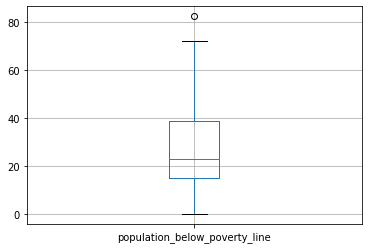

In [0]:
valori.boxplot(column='population_below_poverty_line')

Text(0.5, 1.0, 'Distribution poverty line')

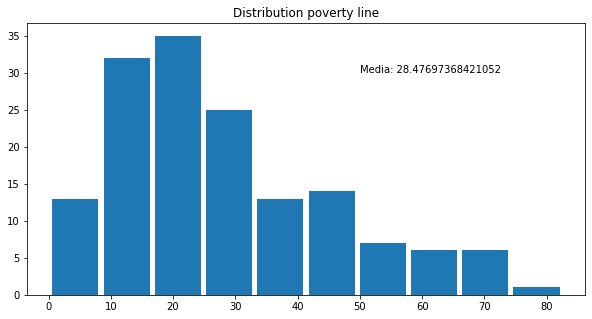

In [0]:
stringa='Media: '+str(media)

fig = plt.figure(figsize=(10,5))
plt.hist(valori['population_below_poverty_line'],bins='auto',rwidth=0.9)
plt.text(50, 30, stringa)
plt.title("Distribution poverty line")

In [0]:
country_info_11 = country_info_11[country_info_11['population_below_poverty_line']<50]

In [0]:
country_difference_ratio = pd.merge(country_difference,country_info_11,how='inner',left_on='country',right_on='country_name')

In [0]:
country_difference_ratio.drop(columns=['country_name','population_y'],inplace=True)

In [0]:
country_difference_ratio

,country,borrowed,lent,difference,population_x,ratio,population_below_poverty_line
0,Philippines,97045925.0,3190391.83,-93855533.17,104918090,-0.894560,21.6
1,Peru,78702800.0,210138.88,-78492661.12,32165485,-2.440276,22.7
2,Kenya,63650255.0,619401.25,-63030853.75,49699862,-1.268230,43.4
3,Paraguay,53715200.0,66041.90,-53649158.10,6811297,-7.876497,22.2
4,Cambodia,50829425.0,211303.13,-50618121.87,16005373,-3.162571,17.7
...,...,...,...,...,...,...,...
59,Papua New Guinea,50000.0,12728.95,-37271.05,8251162,-0.004517,37.0
60,Bhutan,15625.0,3205.37,-12419.63,807610,-0.015378,13.3
61,Mauritania,15000.0,269.49,-14730.51,4420184,-0.003333,31.0
62,Botswana,8000.0,23897.32,15897.32,2291661,0.006937,30.3


### Result

In [0]:
highest_ratio_notPoverty = country_difference_ratio.sort_values(by='ratio',ascending=False)
print("Country highest ratio with constraint: "+highest_ratio.iloc[0]['country'])

Country highest ratio with constraint: Canada


## Task 12
- For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.

In [0]:
loanYear.columns = ['loan_id','country','disburse_time','planned_expiration_time','duration',
                    'funded_amount','loan_amount','currency','year_disburse']

In [0]:
loanYear = loanYear[loanYear['duration']>0]

In [0]:
loanYear['currency'] = loanYear.apply(lambda x: str(x['currency']),axis=1)

In [0]:
loanYear.head()

,loan_id,country,disburse_time,planned_expiration_time,duration,funded_amount,loan_amount,currency,year_disburse
0,657307,Philippines,2013-12-22 08:00:00.000 +0000,2014-02-14 03:30:06.000 +0000,53.0,125.0,125.0,PHP,2013
1,657259,Honduras,2013-12-20 08:00:00.000 +0000,2014-03-26 22:25:07.000 +0000,96.0,400.0,400.0,HNL,2013
2,658010,Pakistan,2014-01-09 08:00:00.000 +0000,2014-02-15 21:10:05.000 +0000,37.0,400.0,400.0,PKR,2014
3,659347,Kyrgyzstan,2014-01-17 08:00:00.000 +0000,2014-02-21 03:10:02.000 +0000,34.0,625.0,625.0,KGS,2014
4,656933,Philippines,2013-12-17 08:00:00.000 +0000,2014-02-13 06:10:02.000 +0000,57.0,425.0,425.0,PHP,2013


In [0]:
currency_included.head()

,currency,conversion
0,PHP,True
1,HNL,False
2,PKR,False
3,KGS,False
4,USD,False


In [0]:
len(firstBlock), len(secondBlock)

(271075, 758180)

In [0]:
secondBlock['loan_amount_conversion'] = secondBlock['loan_amount']

In [0]:
secondBlock.drop(columns=['conversion'],inplace=True)

In [0]:
currency_firstBlock = firstBlock['currency'].unique()
firstBlock.groupby('currency')['country'].count()

currency
BRL       462
CNY       125
EUR      2180
IDR      7862
ILS       371
INR     14707
MXN      9375
PHP    233833
THB        50
TRY      1974
ZAR       136
Name: country, dtype: int64

In [0]:
dateCurrency = firstBlock[['loan_id','disburse_time','currency']]

In [0]:
'''val = range(len(currency_firstBlock))
assignment = list(map(lambda x,y: (x,y),currency_firstBlock, val))
index_currency = pd.DataFrame(assignment)
index_currency.columns=['currency','index_currency']

firstBlock_test = pd.merge(firstBlock,index_currency,how='inner',on='currency')'''

In [0]:
def fill_list(currency, dates):
  date_list=list()
  for key in dates:
    currency_rate = (currency,currency_object.get_rate(currency,'USD',key))
    pair = (key,currency_rate)
    date_list.append(pair)
  print("Trovato rate currency "+str(currency))
  return date_list

def controllaPerformance(df,currency_list):
  currency_list = dateCurrency['currency'].unique()
  dict_currency_list = list()
  for i in currency_list:
    print(i)
    loan_currency = df[df['currency']==i][['disburse_time','currency']]
    date_loan_currency = set(loan_currency['disburse_time'].tolist()) #drop duplicates
    ris = fill_list(i,date_loan_currency)
    #print(ris)
    dict_currency_list.append(ris)

  return dict_currency_list

In [0]:
'''inizio=datetime.now()
print("Inizio: "+inizio.strftime("%H:%M:%S"))
controllaPerformance(firstBlock,currency_firstBlock)
fine=datetime.now()
print("Fine: "+fine.strftime("%H:%M:%S"))
diff= fine - inizio
diff'''

Inizio: 08:09:56
PHP
Trovato rate currency PHP
ILS
Trovato rate currency ILS
MXN
Trovato rate currency MXN
IDR


KeyboardInterrupt: ignored

In [0]:
inizio=datetime.now()
print("Inizio: "+inizio.strftime("%H:%M:%S"))
dict_currency_list = controllaPerformance_map(firstBlock, currency_firstBlock)
fine=datetime.now()
print("Fine: "+fine.strftime("%H:%M:%S"))
diff= fine - inizio
diff

Inizio: 13:13:03
PHP
ILS
MXN
IDR
INR
EUR
ZAR
TRY
CNY
BRL
THB
Trovato rate currency PHP
Trovato rate currency ILS
Trovato rate currency MXN
Trovato rate currency IDR
Trovato rate currency INR
Trovato rate currency EUR
Trovato rate currency ZAR
Trovato rate currency TRY
Trovato rate currency CNY
Trovato rate currency BRL
Trovato rate currency THB
Fine: 13:29:27


datetime.timedelta(0, 983, 564117)

In [0]:
date_currency.head()

,date,currency
0,2016-02-16 08:00:00,"[(PHP, 0.0210480679), (MXN, 0.0530559687), (ID..."
1,2015-08-11 07:00:00,"[(PHP, 0.0217083947), (MXN, 0.0614702824), (ID..."
2,2017-04-16 07:00:00,"[(PHP, 0.0202152746)]"
3,2015-04-20 07:00:00,"[(PHP, 0.0225980485), (MXN, 0.0651106024), (ID..."
4,2013-06-13 07:00:00,"[(PHP, 0.0232682091), (MXN, 0.0777899817), (ID..."


In [0]:
date_currency = date_currency.explode('currency').reset_index()

In [0]:
date_currency.head()

,index,date,currency
0,0,2016-02-16 08:00:00,"(PHP, 0.0210480679)"
1,0,2016-02-16 08:00:00,"(MXN, 0.0530559687)"
2,0,2016-02-16 08:00:00,"(IDR, 7.44506e-05)"
3,0,2016-02-16 08:00:00,"(INR, 0.0146154702)"
4,0,2016-02-16 08:00:00,"(EUR, 1.1166)"


In [0]:
date_currency.head()

,index,disburse_time,curr_list,currency,rate
0,0,2016-02-16 08:00:00,"(PHP, 0.0210480679)",PHP,0.021048
1,0,2016-02-16 08:00:00,"(MXN, 0.0530559687)",MXN,0.053056
2,0,2016-02-16 08:00:00,"(IDR, 7.44506e-05)",IDR,0.000074
3,0,2016-02-16 08:00:00,"(INR, 0.0146154702)",INR,0.014615
4,0,2016-02-16 08:00:00,"(EUR, 1.1166)",EUR,1.116600


### Test methods

In [0]:
def first_method1(df):
    df['loan_amount_conversion'] = df['loan_amount']
    return df

def second_method1(df):
    df['loan_amount_conversion'] = df.apply(lambda x: x['loan_amount'],axis=1)
    return df

In [0]:
#secondBlock_test = secondBlock[:10000]

In [0]:
#%timeit first_method1(secondBlock_test)

In [0]:
#%timeit second_method1(secondBlock_test)

In [0]:
secondBlock['currency'].unique()

array(['HNL', 'PKR', 'KGS', 'USD', 'BIF', 'XOF', 'MNT', 'PEN', 'AMD',
       'GHS', 'TZS', 'GTQ', 'PYG', 'NIO', 'KES', 'UGX', 'RWF', 'MZN',
       'AZN', 'TJS', 'MGA', 'BOB', 'VND', 'COP', 'JOD', 'YER', 'CLP',
       'KHR', 'ALL', 'NPR', 'SLL', 'LBP', 'XAF', 'WST', 'DOP', 'LRD',
       'LAK', 'MMK', 'GEL', 'HTG', 'UAH', 'SDG', 'CRC', 'EGP', 'ZMW',
       'ZMK', 'BZD', 'MWK', 'SRD', 'SSP', 'NGN', 'SBD', 'MDL', 'LSL',
       'NAD', 'VUV', 'XCD', 'ZWD'], dtype=object)

### Merge two parts divided before in all-one (loan_USD)

In [0]:
loan_USD = pd.concat([firstBlock,secondBlock],axis=0,sort=False)

In [0]:
loan_USD['year_expiration']=loan_USD.apply(lambda x: x['planned_expiration_time'].date().year,axis=1)

In [0]:
loan_USD['difference_years'] = loan_USD['year_expiration'] - loan_USD['year_disburse']

In [0]:
loan_USD = loan_USD[['loan_id','disburse_time',
                          'planned_expiration_time','year_disburse','year_expiration','difference_years','loan_amount_conversion']]

In [0]:
loan_USD['loan_amount_conversion'] = round(loan_USD['loan_amount_conversion'],2)

In [0]:
loan_USD['difference_years'].unique()

array([1, 0, 4, 5])

In [0]:
loan_USD.head()

,loan_id,disburse_time,planned_expiration_time,year_disburse,year_expiration,difference_years,loan_amount_conversion
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,2013,2014,1,2.81
1,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,2013,2014,1,9.60
2,657341,2013-12-17 08:00:00,2014-02-14 08:30:03,2013,2014,1,9.60
3,657884,2013-12-17 08:00:00,2014-02-15 18:10:08,2013,2014,1,15.25
4,657867,2013-12-17 08:00:00,2014-02-15 18:50:02,2013,2014,1,6.21


In [0]:
sameYear_loan_USD = loan_USD[loan_USD['year_disburse']==loan_USD['year_expiration']]
index_sameYear = sameYear_loan_USD.index

In [0]:
distribution_loan_USD = sameYear_loan_USD[['loan_id','loan_amount_conversion','year_expiration']]

In [0]:
distribution_loan_USD.columns = ['loan_id','loan_amount_USD','year']
distribution_loan_USD.head()

,loan_id,loan_amount_USD,year
91,659605,7.76,2014
92,660485,5.54,2014
93,659100,4.99,2014
94,659266,17.74,2014
95,663198,2.77,2014


In [0]:
differentYear_loan_USD = loan_USD.drop(index_sameYear, axis=0)

In [0]:
differentYear_loan_USD['day_disburse'] = differentYear_loan_USD.apply(lambda x: x['disburse_time'].date().day,axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
differentYear_loan_USD.head()

,loan_id,disburse_time,planned_expiration_time,year_disburse,year_expiration,difference_years,loan_amount_conversion,day_disburse
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,2013,2014,1,2.81,22
1,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,2013,2014,1,9.60,17
2,657341,2013-12-17 08:00:00,2014-02-14 08:30:03,2013,2014,1,9.60,17
3,657884,2013-12-17 08:00:00,2014-02-15 18:10:08,2013,2014,1,15.25,17
4,657867,2013-12-17 08:00:00,2014-02-15 18:50:02,2013,2014,1,6.21,17


In [0]:
differentYear_loan_USD['month_disburse'] = differentYear_loan_USD.apply(lambda x: x['disburse_time'].date().month,axis=1)
differentYear_loan_USD['day_expiration'] = differentYear_loan_USD.apply(lambda x: x['planned_expiration_time'].date().day,axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
'''different_loan_test = differentYear_loan_USD[differentYear_loan_USD['difference_years']==1]
len(different_loan_test)'''

140220

In [0]:
def check_leap(year):
  if calendar.isleap(year)==True:
    return 366
  else:
    return 365

In [0]:
def compute_amount_year(loan,den,val_num,range_year):
  val_year = round((loan * val_num) / den,2)
  print("Anno: "+str(range_year)+" - Val: "+str(val_year))
  return (range_year,val_year)

In [0]:
def compute_distribution(id,loan,day_d,month_d,year_d,day_e,year_e):
  days_month = calendar.monthrange(year_d,month_d)[1]
  values = []
  year_range = set(range(year_d,year_e+1))
  lower_upper = set([year_d,year_e])
  year_ris = list(year_range - lower_upper)
  difference = days_month - day_d
  if (len(year_ris)==0):
    values.append([difference,day_e])
  else:
    years_day = list(map (check_leap, year_ris))
    values.append([[difference],years_day,[day_e]])
    values = list(itertools.chain(*values))

  values = list(itertools.chain(*values))
  year_range=list(year_range)
  year_range.sort()
  den=sum(values)
  result_list = list(map (functools.partial(compute_amount_year, loan,den), values, list(year_range)))
  return result_list

In [0]:
differentYear_loan_USD.iloc[:2]

,loan_id,disburse_time,planned_expiration_time,year_disburse,year_expiration,difference_years,loan_amount_conversion,day_disburse,month_disburse,day_expiration
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,2013,2014,1,2.81,22,12,14
1,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,2013,2014,1,9.60,17,12,13


In [0]:
differentYear_loan_USD['dict_distribution']=differentYear_loan_USD.apply(lambda x: compute_distribution(x['loan_id'],x['loan_amount_conversion'],
                                                                                              x['day_disburse'],x['month_disburse'],
                                                                                              x['year_disburse'],x['day_expiration'],x['year_expiration']),axis=1)

Streaming output truncated to the last 5000 lines.
Anno: 2015 - Val: 56.62
Anno: 2014 - Val: 166.94
Anno: 2015 - Val: 58.06
Anno: 2014 - Val: 121.97
Anno: 2015 - Val: 53.03
Anno: 2014 - Val: 98.57
Anno: 2015 - Val: 51.43
Anno: 2014 - Val: 148.39
Anno: 2015 - Val: 51.61
Anno: 2014 - Val: 435.14
Anno: 2015 - Val: 264.86
Anno: 2014 - Val: 121.97
Anno: 2015 - Val: 53.03
Anno: 2014 - Val: 84.56
Anno: 2015 - Val: 40.44
Anno: 2014 - Val: 652.7
Anno: 2015 - Val: 397.3
Anno: 2017 - Val: 33.33
Anno: 2018 - Val: 66.67
Anno: 2017 - Val: 25.0
Anno: 2018 - Val: 75.0
Anno: 2014 - Val: 42.59
Anno: 2015 - Val: 7.41
Anno: 2014 - Val: 107.81
Anno: 2015 - Val: 42.19
Anno: 2017 - Val: 18.75
Anno: 2018 - Val: 56.25
Anno: 2014 - Val: 42.59
Anno: 2015 - Val: 7.41
Anno: 2016 - Val: 253.12
Anno: 2017 - Val: 421.88
Anno: 2016 - Val: 70.59
Anno: 2017 - Val: 129.41
Anno: 2016 - Val: 0.0
Anno: 2017 - Val: 125.0
Anno: 2016 - Val: 117.39
Anno: 2017 - Val: 332.61
Anno: 2016 - Val: 35.29
Anno: 2017 - Val: 64.71
Anno: 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
loan_distribution = differentYear_loan_USD[['loan_id','dict_distribution']]
loan_distribution.head()

,loan_id,dict_distribution
0,657307,"[(2013, 1.1), (2014, 1.71)]"
1,656933,"[(2013, 4.98), (2014, 4.62)]"
2,657341,"[(2013, 4.8), (2014, 4.8)]"
3,657884,"[(2013, 7.36), (2014, 7.89)]"
4,657867,"[(2013, 3.0), (2014, 3.21)]"


In [0]:
loan_distribution = loan_distribution.explode('dict_distribution')
loan_distribution

,loan_id,dict_distribution
0,657307,"(2013, 1.1)"
0,657307,"(2014, 1.71)"
1,656933,"(2013, 4.98)"
1,656933,"(2014, 4.62)"
2,657341,"(2013, 4.8)"
...,...,...
1029146,1429632,"(2018, 193.55)"
1029155,1431373,"(2017, 342.11)"
1029155,1431373,"(2018, 157.89)"
1029158,1226583,"(2016, 183.33)"


In [0]:
loan_distribution['year'] = loan_distribution.apply(lambda x: x['dict_distribution'][0],axis=1)
loan_distribution['loan_amount_USD'] = loan_distribution.apply(lambda x: x['dict_distribution'][1],axis=1)

loan_distribution = loan_distribution.reset_index()

In [0]:
loan_distribution.drop(columns=['index','dict_distribution'],inplace=True)

In [0]:
loan_distribution

,loan_id,year,loan_amount_USD
0,657307,2013,1.10
1,657307,2014,1.71
2,656933,2013,4.98
3,656933,2014,4.62
4,657341,2013,4.80
...,...,...,...
286224,1429632,2018,193.55
286225,1431373,2017,342.11
286226,1431373,2018,157.89
286227,1226583,2016,183.33


### Merge file loan same Year disburse and expiration with other file different Year

In [0]:
distribution_loan = pd.concat([distribution_loan_USD,loan_distribution],axis=0,sort=False)
distribution_loan.head()

,loan_id,loan_amount_USD,year
91,659605,7.76,2014
92,660485,5.54,2014
93,659100,4.99,2014
94,659266,17.74,2014
95,663198,2.77,2014


In [0]:
year_distribution = pd.DataFrame(distribution_loan.groupby('year')['loan_amount_USD'].sum()).reset_index(level=0)

In [0]:
year_distribution['loan_amount_USD_format'] = year_distribution.apply(lambda x: format(x['loan_amount_USD'],'f'),axis=1)

,year,loan_amount_USD,loan_amount_USD_format
0,2011,1.004375e+06,1004375.350000
1,2012,9.928101e+07,99281011.330001
2,2013,1.079177e+08,107917749.449999
3,2014,1.334364e+08,133436355.799999
4,2015,1.313179e+08,131317875.300002
5,2016,1.301017e+08,130101678.000002
6,2017,1.416665e+08,141666486.019999
7,2018,7.116009e+06,7116008.890000


### Result

In [0]:
year_distribution

,year,loan_amount_USD,loan_amount_USD_format
0,2011,1.004375e+06,1004375.350000
1,2012,9.928101e+07,99281011.330001
2,2013,1.079177e+08,107917749.449999
3,2014,1.334364e+08,133436355.799999
4,2015,1.313179e+08,131317875.300002
5,2016,1.301017e+08,130101678.000002
6,2017,1.416665e+08,141666486.019999
7,2018,7.116009e+06,7116008.890000
